In [490]:
from headers import *

In [491]:
class DMP():
	
	def __init__(self):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = self.alphaz/3
		
		self.time_steps = 100
		self.tau = self.time_steps

		self.dimensions = 2
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = 1000
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
# 		t_range_2 = npy.linspace(0,self.time_steps,self.time_steps)        
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase
		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)

	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
		self.eta[:,0] = vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
		self.eta[:,1] = vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])

	def learn_DMP(self):		
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP()
    
        
	def initialize_rollout(self,start,goal):
		self.tau = 1
		self.pos_var = copy.deepcopy(start)
		self.pos_roll[0] = copy.deepcopy(start)
		self.vel_var = npy.zeros(self.dimensions)
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.goal = goal
		self.dt = 1./self.rollout_time   

	def calc_rollout_force(self,roll_time):
		den = 0
		time = float(roll_time)/self.rollout_time
		for i in range(self.number_kernels):
			self.force_var += self.basis(i,time)*self.weights[i]            
			den += self.basis(i,time)
		self.force_var *= (self.goal-self.pos_roll[0])*self.calc_phase(time)/den
		self.force_roll[roll_time] = self.force_var        
        
	def calc_rollout_acceleration(self,time):        
		self.acc_var = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_var) - self.tau*self.vel_var) + self.force_var)
		self.acc_roll[time] = self.acc_var
        
	def calc_rollout_vel(self,time):
		self.vel_var += (1/self.tau)*self.acc_var*self.dt
		self.vel_roll[time] = self.vel_var

	def calc_rollout_pos(self,time):
# 		self.pos_var += self.vel_var * self.dt
		self.pos_var += self.vel_var*self.dt + 0.5*self.acc_var*(self.dt**2)
		self.pos_roll[time] = self.pos_var        

	def rollout(self,start,goal):

		# For all time: 
		self.initialize_rollout(start,goal)
		roll_time = 0
		for i in range(self.rollout_time):        
			self.calc_rollout_force(i)
			self.calc_rollout_acceleration(i)
			self.calc_rollout_vel(i)
			self.calc_rollout_pos(i)   
# 			self.calc_rollout_force(roll_time)
# 			self.calc_rollout_acceleration(roll_time)
# 			self.calc_rollout_vel(roll_time)
# 			self.calc_rollout_pos(roll_time)               
# 			print(self.pos_var)
        

In [492]:
# dmp = DMP()	
# pos = npy.load("position.npy")
# vel = npy.load("velocity.npy")
# acc = npy.load("acceleration.npy")
# dmp.load_trajectory(pos,vel,acc)
# dmp.initialize_variables()
# # dmp.update_target_force()
# dmp.update_target_force_itau()
# dmp.learn_DMP()

# tr = npy.linspace(0,99,100)
# plt.plot(tr, dmp.target_forces)
# plt.title("With TAU")
# plt.show()

In [493]:
dmp = DMP()	
pos = npy.load("position.npy")
vel = npy.load("velocity.npy")
acc = npy.load("acceleration.npy")
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
dmp.update_target_force()
# dmp.update_target_force_itau()
dmp.learn_DMP()

tr = npy.linspace(0,99,100)
# plt.plot(tr, dmp.target_forces)
# plt.title("Without Tau")
# plt.show()

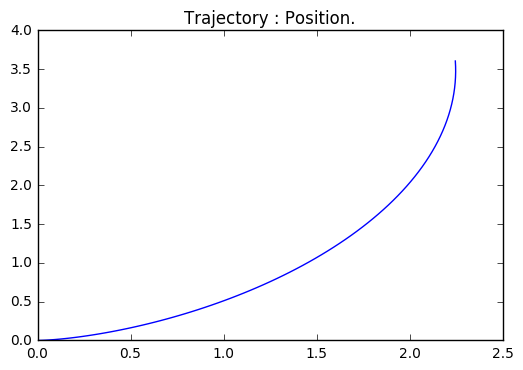

array([ 2.24608319,  3.605693  ])

In [494]:
plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
plt.title("Trajectory : Position.")
plt.show()
dmp.demo_pos[99]

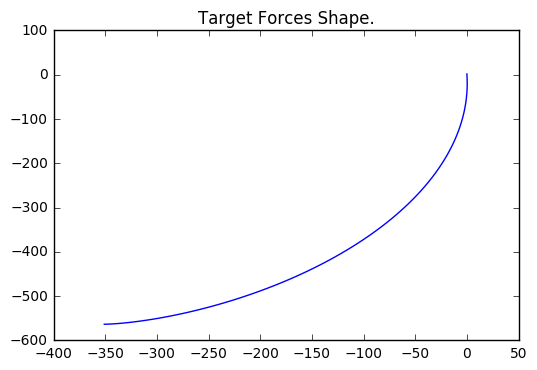

In [495]:
plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Target Forces Shape.")
plt.show()

In [496]:
# b = npy.zeros((dmp.number_kernels,100))
# for i in range(dmp.number_kernels):
#     for t in range(100):
#         b[i,t]=dmp.basis(i,t)        
#     plt.plot(tr,b[i])    

# plt.show()

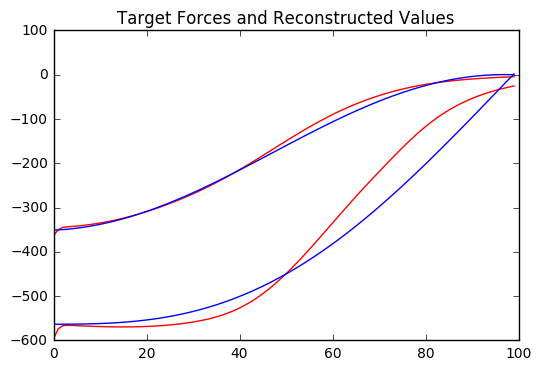

In [497]:
force = npy.zeros((100,2))
dmp.goal = npy.array([2.2,3.6])
# dmp.goal = copy.deepcopy(dmp.demo_pos[99])

for t in range(100):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)
    force[t,0]*=dmp.goal[0]*dmp.calc_phase(t)/den
    force[t,1]*=dmp.goal[1]*dmp.calc_phase(t)/den
    
# plt.plot(tr,force)
# plt.show()

plt.plot(tr,force,'r')
plt.plot(tr,dmp.target_forces,'b')
# plt.plot([-,5],[50,100])
plt.title("Target Forces and Reconstructed Values")
plt.show()

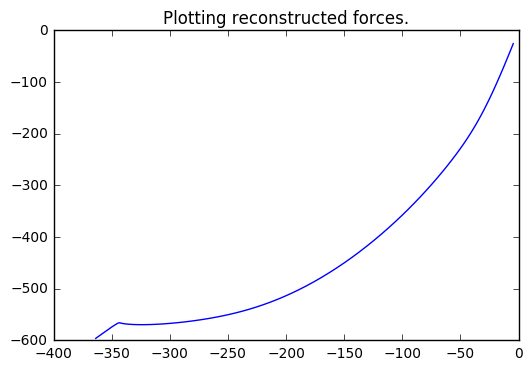

In [498]:
plt.plot(force[:,0],force[:,1])
# plt.plot(force[0:,0],force[0:2,1])
plt.title("Plotting reconstructed forces.")
plt.show()

In [499]:
start = npy.zeros(2)
goal = npy.array([1.,1.])
dmp.rollout(start, goal)

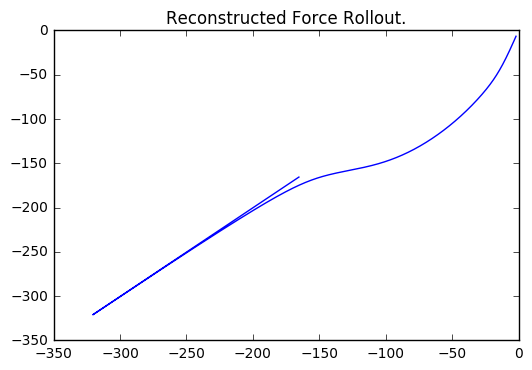

In [500]:
t1 = 0
t2 = dmp.rollout_time
# plt.plot(dmp.force_roll[:,0],dmp.force_roll[:,1])
plt.plot(dmp.force_roll[t1:t2,0],dmp.force_roll[t1:t2,1])
plt.title("Reconstructed Force Rollout.")
plt.show()

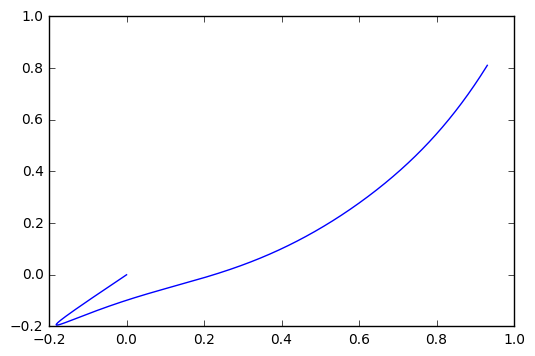

In [503]:
plt.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1])
# plt.plot(dmp.acc_roll[:,0],dmp.acc_roll[:,1])

# plt.plot(tr,dmp.vel_roll,'g')
# plt.plot(tr,dmp.acc_roll,'b')
tr2= npy.linspace(0,dmp.rollout_time,dmp.rollout_time)
# plt.plot(tr2,dmp.force_roll,'b')
# plt.plot(tr,dmp.pos_roll,'r')

plt.show()